In [1]:
import ase
import matplotlib.pyplot as plt
import numpy as np

import abtem

(walkthrough:atomic_models)=
# Atomic models
*ab*TEM uses the Atomic Simulation Environment ([ASE](https://wiki.fysik.dtu.dk/ase/)) for creating model atomic structures {cite}`ase`. ASE is a set of open-source tools and Python modules for setting up, manipulating, visualizing and analyzing atomistic simulations. It is also used in conjunction with other simulation codes such as [GPAW](https://wiki.fysik.dtu.dk/gpaw/) for running density functional theory (DFT) simulations. 

Here, we introduce the set of features of ASE needed for image simulations; please refer to the ASE [documentation](https://wiki.fysik.dtu.dk/ase/ase/ase.html) for a more general introduction.

## `Atoms`
The `Atoms` object defines a collection of atoms, ie. our specimen. Here is how to set up an N<sub>2</sub> molecule by directly specifying the position of the two nitrogen atoms (in units of Ångstrom, which is the default in both ASE and *ab*TEM).

In [2]:
n2 = ase.Atoms(
    "N2", positions=[(0.0, 0.0, 0.0), (0.0, 0.0, 1.10)], cell=[2, 2, 2], pbc=True
)

A basic *ab*TEM simulation only uses the positional coordinates, atomic numbers and the unit cell for creating electrostatic potentials using the independent atom model. 

The atomic numbers are an array of integers.

In [3]:
n2.numbers

array([7, 7])

The $xyz$ positions are an $N\times 3$ array, where $N$ is the number of atoms.

In [4]:
n2.positions

array([[0. , 0. , 0. ],
       [0. , 0. , 1.1]])

The unit cell associated with the atoms is slightly more complicated. When we access it here, we get three numbers, corresponding to the length of each side of the cell. This is because the unit vectors of this cell are orthogonal and axis-aligned, hence the cell can be given as just the sides of a rectangular cuboid.

In [5]:
n2.cell

Cell([2.0, 2.0, 2.0])

In general, a cell is defined by three lattice vectors. We can convert the `Cell` to a NumPy array, to print the full representation of the cell below, where each row represents a lattice vector.

In [6]:
np.array(n2.cell)

array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]])

```{important}
The multislice algorithm requires that the unit vectors of the cell are orthogonal and axis-aligned, and additionally, the cell must be periodic. Fulfilling both of these constraints when creating a desired model structure is not always trivial, see [our advanced tutorial](tutorials:advanced_atomic_models:orthogonal) for an introduction to the problem and tools *ab*TEM implements to help solve it.
```

## Import/export

In addition to defining structures using code, ASE can import all the common atomic structure formats, see a full list [here](https://wiki.fysik.dtu.dk/ase/ase/io/io.html). Below we import a .cif-file defining a unit cell of strontium titanate (SrTiO<sub>3</sub>). 

In [7]:
srtio3 = ase.io.read("./data/SrTiO3.cif")

```{warning}
Unlike some other multislice simulation codes, *ab*TEM does not use any Debye-Waller factors or partial occupations embedded in structure files. Our philosophy is that those should be explicitly modeled.
```

Of course, we can also write the structure back to disk.  

In [8]:
ase.io.write("./data/SrTiO3.cif", srtio3)

## Visualizing structures
The simplest way to visualize the atoms is our `show_atoms` function. This creates a `matplotlib` figure of a 2D orthogonal projection of the structure perpendicular to a specified plane (default being the `xy` plane that is perpendicular to the default propagation direction in *ab*TEM).

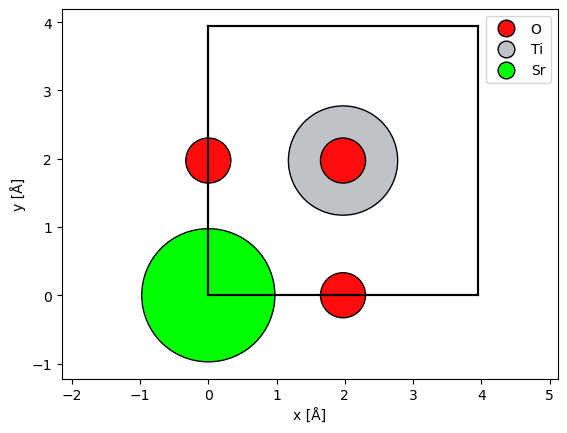

In [9]:
abtem.show_atoms(
    srtio3,
    plane="xy",  # show a view perpendicular to the 'xy' plane
    scale=0.5,  # scale atoms to 0.5 of their covalent radii; default is 0.75
    legend=True,  # show a legend with the atomic symbols
);

The multislice algorithm requires periodic boundary conditions, and thus we should imagine that the atoms at a boundary have an equivalent image at the opposite side. We can show the periodic images of the boundary atoms by setting `show_periodic=True`.

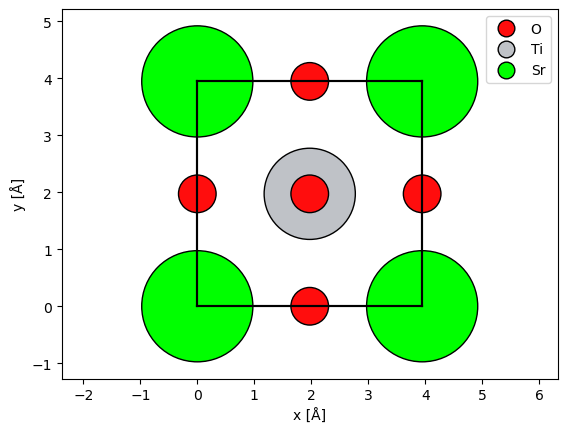

In [10]:
abtem.show_atoms(
    srtio3,
    show_periodic=True,
    scale=0.5,
    legend=True,
);

Alternatively, we may center a copy of the atoms (copied to avoid changing the original atoms) before displaying them using the `center` method, but this may not be ideal for visualizing the potential.

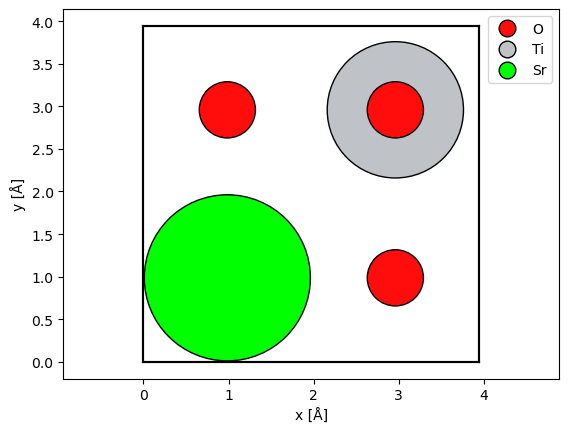

In [11]:
centered_srtio3 = srtio3.copy()
centered_srtio3.center()

abtem.show_atoms(
    centered_srtio3,
    scale=0.5,
    legend=True,
);

## Manipulating structures

The structure you import or build may not match your requirements or the requirements of *ab*TEM. The most commonly needed manipulation is to repeat the structure to create a supercell.

For many more examples, see our [tutorial on advanced atomic models](../tutorials/advanced_atomic_models.ipynb), which includes examples on rotating, scaling, and combining structures, and our tools for creating orthogonal periodic supercells that are required for multislice simulations.

### Repeating the structure

It is often necessary to create a larger supercell from a unit cell. For example, you may need to increase the thickness of the structure by repeating it along the $z$-axis.

```{warning}
In STEM, the $xy$-extent of the model structure have to be large enough to accomodate the size of the probe to prevent self-interaction with its periodic images.
```

ASE atomic structures may be repeated simply by multiplying them with a tuple of 3 integers.

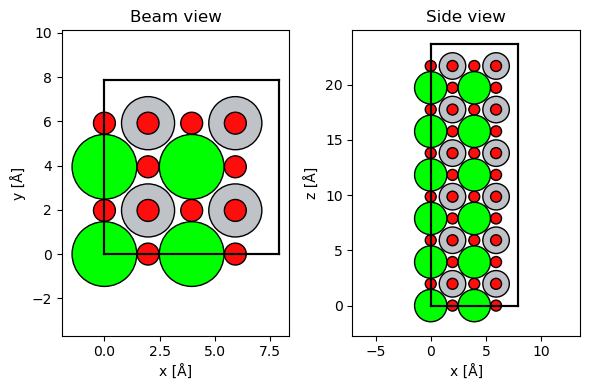

In [12]:
repeated_srtio3 = srtio3 * (2, 2, 6)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
abtem.show_atoms(repeated_srtio3, ax=ax1, title="Beam view")
abtem.show_atoms(repeated_srtio3, ax=ax2, plane="xz", title="Side view")
fig.tight_layout();

Let us then move on to discuss how we create the electrostatic scattering potentials from such atomic structures (click "Potentials" at the bottom-right of the page).